<a href="https://colab.research.google.com/github/mavillan/gb-vpp/blob/main/models/gb-vpp-lstm.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
from google.colab import files
drive.mount('/content/drive', force_remount=True)

!pip install --upgrade kaggle > /dev/null 2>&1
!mkdir -p ~/.kaggle/ && cp /content/drive/MyDrive/kaggle/kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Mounted at /content/drive


In [2]:
!pip uninstall -y tensorflow 
!pip install tensorflow==2.4.3 > /dev/null 2>&1

import tensorflow as tf
print("Tensorflow version " + tf.__version__)

try:
  tpu = tf.distribute.cluster_resolver.TPUClusterResolver()  # TPU detection
  print('Running on TPU ', tpu.cluster_spec().as_dict()['worker'])
except ValueError:
  raise BaseException('ERROR: Not connected to a TPU runtime; please see the previous cell in this notebook for instructions!')

tf.config.experimental_connect_to_cluster(tpu)
tf.tpu.experimental.initialize_tpu_system(tpu)
tpu_strategy = tf.distribute.experimental.TPUStrategy(tpu)

Found existing installation: tensorflow 2.4.3
Uninstalling tensorflow-2.4.3:
  Successfully uninstalled tensorflow-2.4.3
Tensorflow version 2.4.3
Running on TPU  ['10.61.123.154:8470']
INFO:tensorflow:Initializing the TPU system: grpc://10.61.123.154:8470


INFO:tensorflow:Initializing the TPU system: grpc://10.61.123.154:8470


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Clearing out eager caches


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Finished initializing TPU system.


INFO:tensorflow:Found TPU system:


INFO:tensorflow:Found TPU system:


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Cores: 8


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Workers: 1


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Num TPU Cores Per Worker: 8


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:localhost/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:CPU:0, CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:0, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:1, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:2, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:3, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:4, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:5, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:6, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU:7, TPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:TPU_SYSTEM:0, TPU_SYSTEM, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


INFO:tensorflow:*** Available Device: _DeviceAttributes(/job:worker/replica:0/task:0/device:XLA_CPU:0, XLA_CPU, 0, 0)


In [3]:
!mkdir -p input/
!kaggle competitions download -c ventilator-pressure-prediction -p input/ --force

!unzip -o input/sample_submission.csv.zip -d input/
!unzip -o input/train.csv.zip -d input/
!unzip -o input/test.csv.zip -d input/

 94% 71.0M/75.4M [00:00<00:00, 53.5MB/s]
100% 75.4M/75.4M [00:00<00:00, 86.2MB/s]
 94% 131M/139M [00:00<00:00, 159MB/s]
100% 139M/139M [00:00<00:00, 159MB/s]
  0% 0.00/8.50M [00:00<?, ?B/s]
100% 8.50M/8.50M [00:00<00:00, 77.9MB/s]
Archive:  input/sample_submission.csv.zip
  inflating: input/sample_submission.csv  
Archive:  input/train.csv.zip
  inflating: input/train.csv         
Archive:  input/test.csv.zip
  inflating: input/test.csv          


In [4]:
input_path = "input"
subs_path = "/content/drive/MyDrive/kaggle/gb-vpp/subs"
results_path = "/content/drive/MyDrive/kaggle/gb-vpp/results"
artifacts_path = "/content/drive/MyDrive/kaggle/gb-vpp/artifacts"

***

In [5]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import LearningRateScheduler
from tensorflow.keras.optimizers.schedules import ExponentialDecay

from sklearn.metrics import mean_absolute_error as mae
from sklearn.preprocessing import RobustScaler, normalize
from sklearn.model_selection import train_test_split, GroupKFold, KFold

from IPython.display import display

***
## data preparation

In [6]:
SEQ_LEN = 80

In [7]:
train_raw = pd.read_csv(f'{input_path}/train.csv')
test_raw = pd.read_csv(f'{input_path}/test.csv')
submission = pd.read_csv(f'{input_path}/sample_submission.csv')

In [10]:
mapping = {j:i for i,j in enumerate(train_raw.breath_id.unique())}
train_raw["breath_id"] = train_raw.breath_id.map(mapping)

if SEQ_LEN < 80:

    train_raw = (
        train_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(SEQ_LEN)
        .reset_index(drop=True)
    )
    test_raw = (
        test_raw
        .sort_values(["breath_id","time_step"])
        .groupby("breath_id")
        .head(SEQ_LEN)
        .reset_index(drop=True)
    )

In [15]:
def compute_feats(dataframe):
    dataframe = dataframe.copy()

    # time features
    dataframe["time_diff"] = dataframe.groupby("breath_id")["time_step"].diff()
    dataframe['time_since_expiratory']= dataframe['time_step'] * dataframe['u_out']

    # lag features
    lags = [1,2,3]
    for lag in lags:
        dataframe[f"u_in_lag{lag}"] = dataframe.groupby("breath_id")["u_in"].shift(lag).fillna(0)

    # stats on u_in
    dataframe["u_in_cumsum"] = dataframe.groupby("breath_id")["u_in"].cumsum()
    dataframe['u_in_cummean'] =dataframe['u_in_cumsum'] / (dataframe.groupby("breath_id")["id"].cumcount()+1)
    dataframe['u_in_last'] = dataframe.groupby('breath_id')['u_in'].transform('last')
    dataframe['cross1']= dataframe['u_in'] * dataframe['u_out']
    dataframe['cross2']= dataframe['u_in'] * (1 - dataframe['u_out'])
    
    dataframe['vol_diff'] = (dataframe['time_diff']*dataframe['u_in']).fillna(0)
    dataframe['vol_diff_cumsum'] = dataframe.groupby('breath_id')['vol_diff'].cumsum()
    dataframe['vol_diff_cumsum_cut'] = dataframe['vol_diff_cumsum'] * (1 - dataframe["u_out"])

    # gradients of u_in
    def compute_grad_1st(df):
        return np.gradient(df.u_in, 100*df.time_step)
    def compute_grad_2nd(df):
        return np.gradient(df.grad_1st, 100*df.time_step)

    gb_result = dataframe.groupby("breath_id").apply(compute_grad_1st)
    dataframe["grad_1st"] = np.concatenate(gb_result.values)
    gb_result = dataframe.groupby("breath_id").apply(compute_grad_2nd)
    dataframe["grad_2nd"] = np.concatenate(gb_result.values)

    # nan filling
    dataframe["time_diff"] = dataframe["time_diff"].fillna(method="bfill")
    
    # ohe of R&C values    
    dataframe['R'] = dataframe['R'].astype(str)
    dataframe['C'] = dataframe['C'].astype(str)
    dataframe['RC'] = dataframe['R']+dataframe['C']
    dataframe = pd.get_dummies(dataframe)
    return dataframe

train = compute_feats(train_raw)
test  = compute_feats(test_raw)


In [ ]:
targets = train[['pressure']].to_numpy().reshape(-1, SEQ_LEN)

cols_to_exclude_train = exclude = ["id","breath_id","pressure"]
cols_to_exclude_test = exclude = ["id","breath_id",]

train.drop(cols_to_exclude, axis=1, inplace=True)
test.drop(cols_to_exclude_test, axis=1, inplace=True)

In [21]:
scaler = RobustScaler()
train = scaler.fit_transform(train)
test = scaler.transform(test)

In [22]:
train = train.reshape(-1, SEQ_LEN, train.shape[-1])
test = test.reshape(-1, SEQ_LEN, train.shape[-1])

***
## model training

----------------------------------- Fold: 1 ------------------------------------
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional (Bidirectional (None, 80, 600)           801600    
_________________________________________________________________
bidirectional_1 (Bidirection (None, 80, 500)           1702000   
_________________________________________________________________
bidirectional_2 (Bidirection (None, 80, 300)           781200    
_________________________________________________________________
bidirectional_3 (Bidirection (None, 80, 200)           320800    
_________________________________________________________________
dense (Dense)                (None, 80, 50)            10050     
_________________________________________________________________
dense_1 (Dense)              (None, 80, 1)             51        
Total params: 3,615,701
Trainable params:

None

Epoch 1/300

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
118/118 [==============================] - 44s 202ms/step - loss: 3.5147 - val_loss: 0.8494
Epoch 2/300

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009997559, shape=(), dtype=float32).
118/118 [==============================] - 8s 67ms/step - loss: 0.7839 - val_loss: 0.6231
Epoch 3/300

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009995119, shape=(), dtype=float32).
118/118 [==============================] - 8s 66ms/step - loss: 0.6059 - val_loss: 0.5357
Epoch 4/300

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009992679, shape=(), dtype=float32).
118/118 [==============================] - 8s 66ms/step - loss: 0.5500 - val_loss: 0.4867
Epoch 5/300

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990239, shape=(), dtype=float32).
118/118 [================

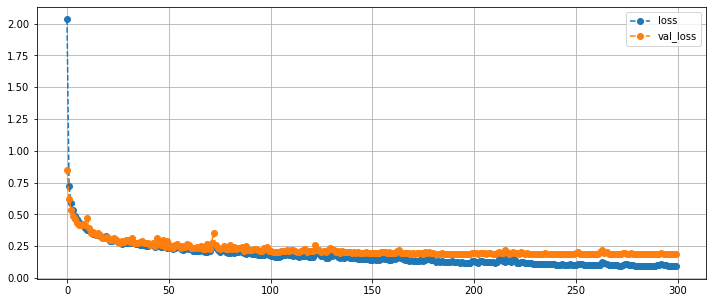

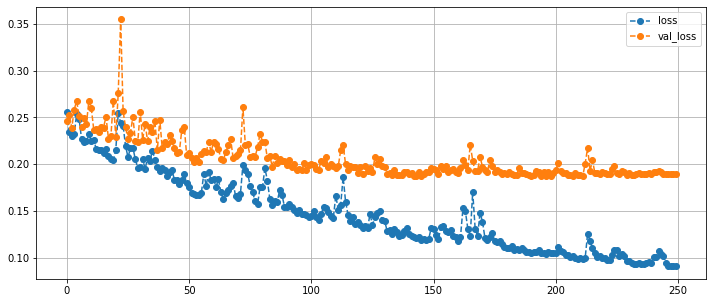

----------------------------------- Fold: 2 ------------------------------------
Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_4 (Bidirection (None, 80, 600)           801600    
_________________________________________________________________
bidirectional_5 (Bidirection (None, 80, 500)           1702000   
_________________________________________________________________
bidirectional_6 (Bidirection (None, 80, 300)           781200    
_________________________________________________________________
bidirectional_7 (Bidirection (None, 80, 200)           320800    
_________________________________________________________________
dense_2 (Dense)              (None, 80, 50)            10050     
_________________________________________________________________
dense_3 (Dense)              (None, 80, 1)             51        
Total params: 3,615,701
Trainable param

None

Epoch 1/300

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
118/118 [==============================] - 44s 198ms/step - loss: 3.2368 - val_loss: 0.8415
Epoch 2/300

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009997559, shape=(), dtype=float32).
118/118 [==============================] - 8s 67ms/step - loss: 0.7696 - val_loss: 0.6059
Epoch 3/300

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009995119, shape=(), dtype=float32).
118/118 [==============================] - 8s 66ms/step - loss: 0.5900 - val_loss: 0.5260
Epoch 4/300

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009992679, shape=(), dtype=float32).
118/118 [==============================] - 8s 66ms/step - loss: 0.5186 - val_loss: 0.5077
Epoch 5/300

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990239, shape=(), dtype=float32).
118/118 [================

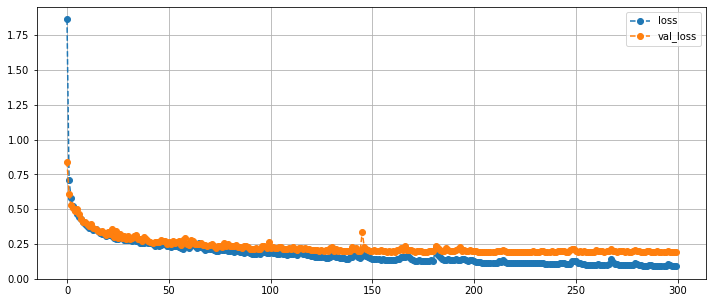

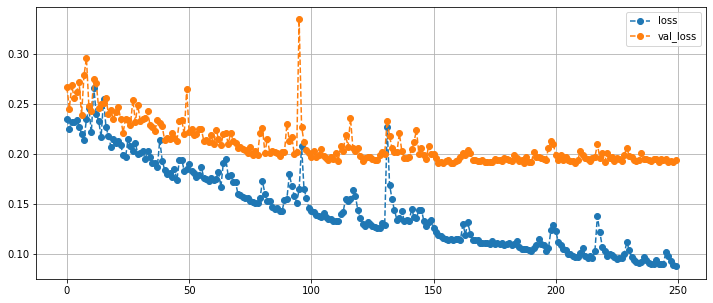

----------------------------------- Fold: 3 ------------------------------------
Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_8 (Bidirection (None, 80, 600)           801600    
_________________________________________________________________
bidirectional_9 (Bidirection (None, 80, 500)           1702000   
_________________________________________________________________
bidirectional_10 (Bidirectio (None, 80, 300)           781200    
_________________________________________________________________
bidirectional_11 (Bidirectio (None, 80, 200)           320800    
_________________________________________________________________
dense_4 (Dense)              (None, 80, 50)            10050     
_________________________________________________________________
dense_5 (Dense)              (None, 80, 1)             51        
Total params: 3,615,701
Trainable param

None

Epoch 1/300

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
118/118 [==============================] - 43s 199ms/step - loss: 3.6165 - val_loss: 0.8950
Epoch 2/300

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009997559, shape=(), dtype=float32).
118/118 [==============================] - 8s 66ms/step - loss: 0.8159 - val_loss: 0.6156
Epoch 3/300

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009995119, shape=(), dtype=float32).
118/118 [==============================] - 8s 66ms/step - loss: 0.6028 - val_loss: 0.5517
Epoch 4/300

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009992679, shape=(), dtype=float32).
118/118 [==============================] - 8s 66ms/step - loss: 0.5425 - val_loss: 0.5134
Epoch 5/300

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990239, shape=(), dtype=float32).
118/118 [================

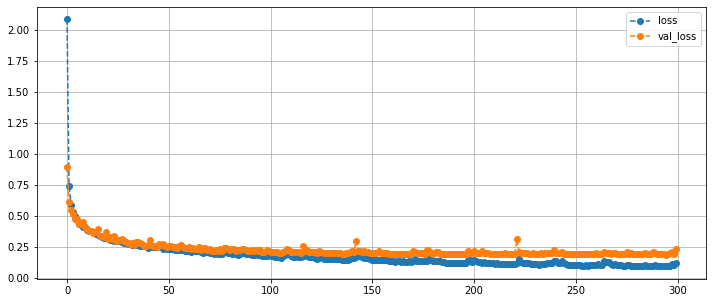

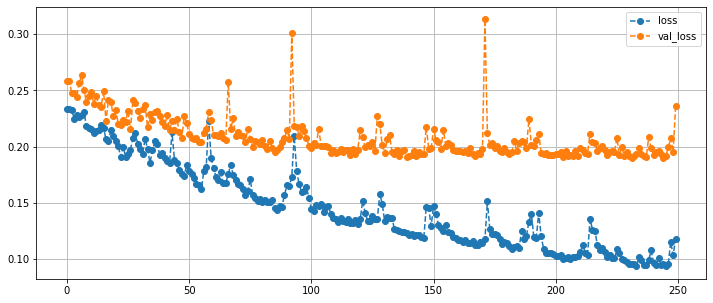

----------------------------------- Fold: 4 ------------------------------------
Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_12 (Bidirectio (None, 80, 600)           801600    
_________________________________________________________________
bidirectional_13 (Bidirectio (None, 80, 500)           1702000   
_________________________________________________________________
bidirectional_14 (Bidirectio (None, 80, 300)           781200    
_________________________________________________________________
bidirectional_15 (Bidirectio (None, 80, 200)           320800    
_________________________________________________________________
dense_6 (Dense)              (None, 80, 50)            10050     
_________________________________________________________________
dense_7 (Dense)              (None, 80, 1)             51        
Total params: 3,615,701
Trainable param

None

Epoch 1/300

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
118/118 [==============================] - 44s 208ms/step - loss: 3.5822 - val_loss: 0.8613
Epoch 2/300

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009997559, shape=(), dtype=float32).
118/118 [==============================] - 8s 67ms/step - loss: 0.7902 - val_loss: 0.6132
Epoch 3/300

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009995119, shape=(), dtype=float32).
118/118 [==============================] - 8s 67ms/step - loss: 0.6023 - val_loss: 0.5401
Epoch 4/300

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009992679, shape=(), dtype=float32).
118/118 [==============================] - 8s 67ms/step - loss: 0.5263 - val_loss: 0.4975
Epoch 5/300

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990239, shape=(), dtype=float32).
118/118 [================

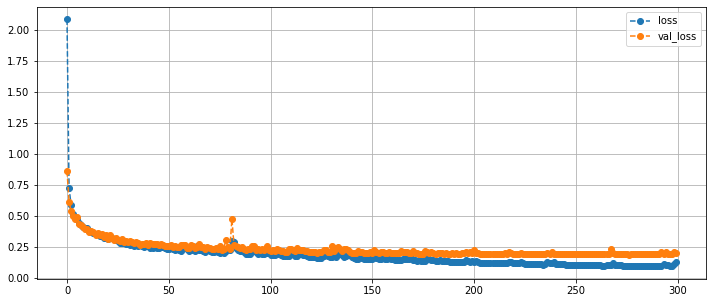

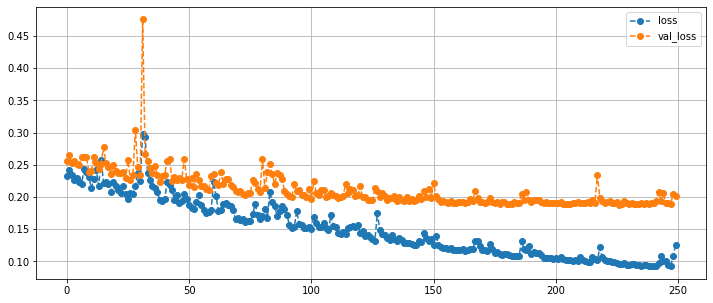

----------------------------------- Fold: 5 ------------------------------------
Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_16 (Bidirectio (None, 80, 600)           801600    
_________________________________________________________________
bidirectional_17 (Bidirectio (None, 80, 500)           1702000   
_________________________________________________________________
bidirectional_18 (Bidirectio (None, 80, 300)           781200    
_________________________________________________________________
bidirectional_19 (Bidirectio (None, 80, 200)           320800    
_________________________________________________________________
dense_8 (Dense)              (None, 80, 50)            10050     
_________________________________________________________________
dense_9 (Dense)              (None, 80, 1)             51        
Total params: 3,615,701
Trainable param

None

Epoch 1/300

Epoch 00001: LearningRateScheduler reducing learning rate to tf.Tensor(0.001, shape=(), dtype=float32).
118/118 [==============================] - 46s 203ms/step - loss: 3.5305 - val_loss: 0.8531
Epoch 2/300

Epoch 00002: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009997559, shape=(), dtype=float32).
118/118 [==============================] - 8s 66ms/step - loss: 0.7723 - val_loss: 0.6340
Epoch 3/300

Epoch 00003: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009995119, shape=(), dtype=float32).
118/118 [==============================] - 8s 67ms/step - loss: 0.6114 - val_loss: 0.5991
Epoch 4/300

Epoch 00004: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009992679, shape=(), dtype=float32).
118/118 [==============================] - 8s 67ms/step - loss: 0.5483 - val_loss: 0.5453
Epoch 5/300

Epoch 00005: LearningRateScheduler reducing learning rate to tf.Tensor(0.0009990239, shape=(), dtype=float32).
118/118 [================

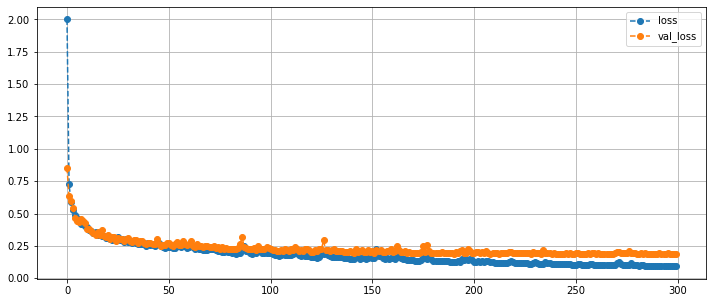

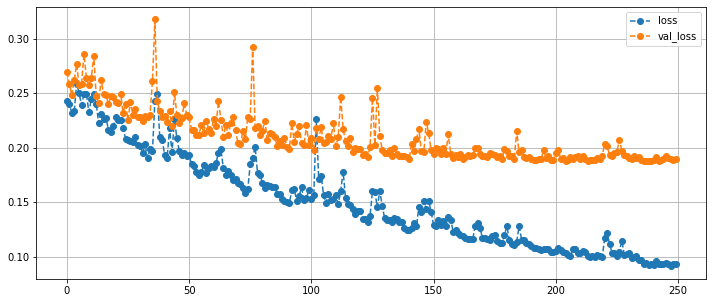

In [23]:
EPOCH = 300
BATCH_SIZE = 512

kf = KFold(n_splits=5, shuffle=True, random_state=2021)
models_by_fold = list()

oof = train_raw[["id","breath_id","u_out","pressure"]].copy()

for fold, (train_idx,valid_idx) in enumerate(kf.split(train, targets)):

    print(f" Fold: {fold+1} ".center(80, "-"))
    X_train, X_valid = train[train_idx], train[valid_idx]
    y_train, y_valid = targets[train_idx], targets[valid_idx]

    with tpu_strategy.scope():
        model = keras.models.Sequential([
            keras.layers.Input(shape=train.shape[-2:]),
            keras.layers.Bidirectional(keras.layers.LSTM(300, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(250, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(150, return_sequences=True)),
            keras.layers.Bidirectional(keras.layers.LSTM(100, return_sequences=True)),
            keras.layers.Dense(50, activation='selu'),
            keras.layers.Dense(1),
        ])
        model.compile(optimizer="adam", loss="mae")
    display(model.summary())

    scheduler = ExponentialDecay(1e-3, 400*((len(train)*0.8)/BATCH_SIZE), 1e-5)
    lr = LearningRateScheduler(scheduler, verbose=1)
    #es = EarlyStopping(monitor="val_loss", patience=15, verbose=1, mode="min", restore_best_weights=True)

    history = model.fit(
        X_train, 
        y_train, 
        validation_data=(X_valid, y_valid), 
        epochs=EPOCH, 
        batch_size=BATCH_SIZE, 
        callbacks=[lr],
        verbose=1,
    )
    models_by_fold.append(model)

    # generate the oof predictions
    x_valid_tf = tf.convert_to_tensor(X_valid, dtype=tf.float32)
    oof_preds = model.call(x_valid_tf, training=False).numpy().squeeze()
    idx = oof.query("breath_id in @valid_idx").index
    oof.loc[idx, "pred"] = oof_preds.ravel()

    plt.figure(figsize=(12,5))
    plt.plot(history.history["loss"], "o--", label="loss")
    plt.plot(history.history["val_loss"], "o--", label="val_loss")
    plt.grid()
    plt.legend(loc="best")
    plt.show()
    
    plt.figure(figsize=(12,5))
    plt.plot(history.history["loss"][50:], "o--", label="loss")
    plt.plot(history.history["val_loss"][50:], "o--", label="val_loss")
    plt.grid()
    plt.legend(loc="best")
    plt.show()


In [24]:
print("mae:", oof.eval("abs(pressure - pred)").mean())
print("mae inspiratory:", oof.query("u_out == 0").eval("abs(pressure - pred)").mean())
print("mae expiratory :", oof.query("u_out == 1").eval("abs(pressure - pred)").mean())

mae: 0.19910630745529212
mae inspiratory: 0.24139623415898287
mae expiratory : 0.1732360695506279


lstm_v3
- mae: 0.1894350191416654
- mae inspiratory: 0.22527142074094628
- mae expiratory : 0.16751262988059495

lstm_v2
- mae: 0.20938487189579605
- mae inspiratory: 0.2124941942660988
- mae expiratory : 0.19958701148249222

lstm_v1
- mae: 0.18086928169783648
- mae inpiratory: 0.2031012730817264
- mae expiratory: 0.16726918940573152

***
## sub generation

In [25]:
all_preds = list()
test_tf = tf.convert_to_tensor(test, dtype=tf.float32)

for model in models_by_fold:
    preds = model.call(test_tf, training=False).numpy().squeeze().ravel()
    all_preds.append(preds)

test_raw["pressure"] = np.mean(all_preds, axis=0)

In [26]:
sub = pd.merge(submission["id"], test_raw[["id","pressure"]], how="left", on="id")
sub["pressure"] = sub["pressure"].fillna(0)
sub.to_csv(f"{subs_path}/sub_lstm.csv", index=False)

In [27]:
oof.to_csv(f"{results_path}/oof_lstm.csv", index=False)

***